In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from matplotlib import colors
from tqdm.notebook import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
soc = QickSoc()
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v6 - tProc out

In [3]:
def plot_decimated(iq_list, soccfg, config, plot_iq=True):
#     fig, axs = plt.subplots(2,1,figsize=(10,10))
    t = soccfg.cycles2us(np.arange(len(iq_list[0][0])), ro_ch=config['ro_ch'])

    for ii, iq in enumerate(iq_list):
#         plot = axs[ii]
        if plot_iq:
            plt.plot(t, iq[0], label="I value, ADC %d"%(config['ro_ch']))
            plt.plot(t, iq[1], label="Q value, ADC %d"%(config['ro_ch']))
            plt.plot(t, np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_ch']))
        else:
            plt.plot(t, iq[0], label="input value, ADC %d"%(config['ro_ch']))
        plt.ylabel("a.u.")
        plt.xlabel("Time [us]")
        plt.title("Averages = " + str(config["soft_avgs"]))
        plt.legend()


In [4]:
def noise(d_buf, verbose=True):
    diq = d_buf[:,0]+1j*d_buf[:,1]
    dmean = np.mean(diq)
    dmag = np.abs(dmean)
    if verbose: print("mean signal is %s (magnitude %f)" % (str(dmean), dmag))
    drotated = diq*np.exp(-1j*np.angle(dmean))
    magerr = np.real(drotated) # noise in the radial direction
    phaerr = np.imag(drotated) # noise in the radial direction
    
    rmsmag = np.std(magerr) # noise in the radial direction
    rmspha = np.std(phaerr) # noise in the azimuth direction
#     plt.hist(np.real(drotated))
    if verbose:
        print("amplitude noise: %f ADU, %f as a fraction of the signal (%f dB)" % (rmsmag, rmsmag/dmag, 20*np.log10(rmsmag/dmag)))
        print("phase noise: %f ADU, %f radians" % (rmspha, rmspha/dmag))
    return dmag, rmsmag, rmspha, magerr, phaerr


# Start configuration

In [6]:
meas_cfg={"res_ch":2,
          'qubit_ch':0,
          "ro_ch":0,
          "f_res": 5500,
          "res_phase": 0,
          "res_gain": 6000,
          "pulse_gain": 6000,
          "pulse_freq": 5500, # MHz, start value
          "nqz":2,
          'adc_trig_offset': 0,
          'length': 10,
          'readout_padding': 0,
          'relax_delay': 50}

# Time of flight

  0%|          | 0/400 [00:00<?, ?it/s]

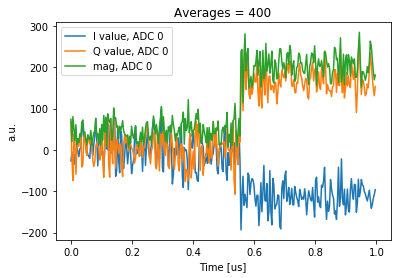

In [7]:
class SingleGenLoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        
        for iCh, ch in enumerate([cfg["res_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=cfg['nqz'], ro_ch=cfg["ro_ch"])
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg["f_res"],gen_ch=ch,ro_ch=cfg["ro_ch"]),
                         gain=cfg['res_gain'],
                         phase=cfg['res_phase'])
            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")
            elif style == "flat_top":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/25, length=int(0.2*length_gen))
                self.set_pulse_registers(ch=ch, style=style, waveform="measure", length=int(0.8*length_gen))

        for iCh, ch in enumerate([cfg["ro_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_ro = soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            self.declare_readout(ch=ch, freq=cfg["f_res"],
                                 length=length_ro,
                                 gen_ch=cfg["res_ch"])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
progconfig={
    'style': 'const',
    'length': 1, # [us]
    'reps': 1,
    'soft_avgs': 400,
    'readout_padding':0.0, 
    'adc_trig_offset': 0}

config={**meas_cfg,**progconfig} #combine configs
prog = SingleGenLoopbackProgram(soccfg, config)

iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
plot_decimated(iq_list, soccfg, config, plot_iq=True)

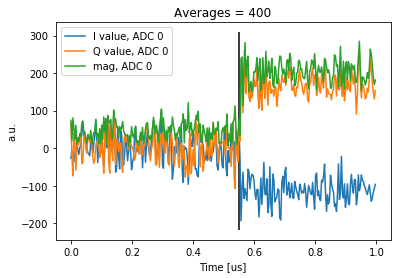

In [8]:
plot_decimated(iq_list, soccfg, config, plot_iq=True)
tof = 0.550
plt.vlines(tof, *plt.ylim())

meas_cfg.update(adc_trig_offset = tof)

# Resonator spectroscopy

  0%|          | 0/201 [00:00<?, ?it/s]

Text(0, 0.5, 'amplitude [ADU]')

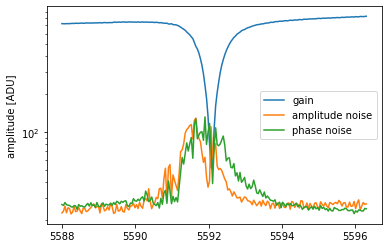

In [9]:
progconfig={
    'style': 'const',
    'length': 10, # [us]
    'reps': 1000,
    'readout_padding':0.0}

config={**meas_cfg,**progconfig} #combine configs

#freqs = np.arange(5588.0, 5596.3, 0.05, dtype=float)
freqs = np.linspace(5588.0, 5596.3, 201, dtype=float)

mags = np.zeros_like(freqs)
noises = np.zeros_like(freqs)
noise_phase = np.zeros_like(freqs)

for i, f in tqdm(list(enumerate(freqs))):
    config['f_res'] = f
    
    prog = SingleGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    
    d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']
    
    dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=False)
    mags[i] = dmag
    noises[i] = rmsmag
    noise_phase[i] = rmspha
    
# plt.semilogy(soc.rfb_get_lo(gen_ch=config['res_ch']) - freqs, mags[:,0])
plt.semilogy(freqs, mags, label='gain')
plt.semilogy(freqs, noises, label='amplitude noise')
plt.semilogy(freqs, noise_phase, label='phase noise')
plt.legend()
plt.ylabel("amplitude [ADU]")

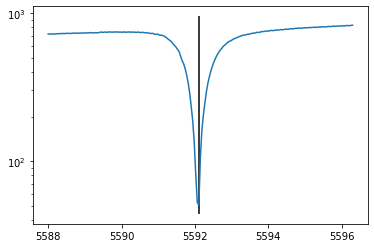

In [10]:
plt.semilogy(freqs, mags, label='gain')
cfreq = 5592.1
plt.vlines(cfreq, *plt.ylim())

meas_cfg.update(f_res = cfreq)

In [11]:
progconfig = {
    'style': 'const',
    'length': 10, # [us]
    'reps': 400 }
config = {**meas_cfg,**progconfig} #combine configs

freqs = config['f_res'] + np.linspace(-2, 2, 51, dtype=float)
gains = np.geomspace(100, 40000, 21).astype(int)

print(gains)


[  100   134   182   245   331   447   603   814  1098  1482  2000  2698
  3641  4912  6628  8944 12068 16283 21971 29645 40000]


In [12]:
mags = np.zeros((len(freqs), len(gains)))
# noises = np.zeros_like(freqs)
# noise_phase = np.zeros_like(freqs)

for iG, g in tqdm(list(enumerate(gains))):
    for iF, f in enumerate(freqs):
        config.update(f_res = f, res_gain = g) 
        
        prog = SingleGenLoopbackProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)

        d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']

        dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=False)
        mags[iF,iG] = dmag
#         noises[i] = rmsmag
#         noise_phase[i] = rmspha
    
# plt.semilogy(soc.rfb_get_lo(gen_ch=config['res_ch']) - freqs, mags[:,0])
# plt.semilogy(freqs, mags, label='gain')
# plt.semilogy(freqs, noises, label='amplitude noise')
# plt.semilogy(freqs, noise_phase, label='phase noise')
# plt.legend()
# plt.ylabel("amplitude [ADU]")

  0%|          | 0/21 [00:00<?, ?it/s]

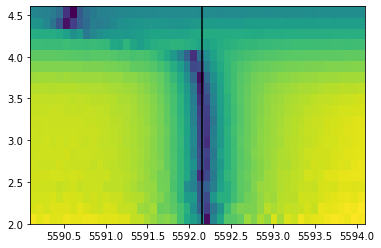

In [14]:
from matplotlib import colors

# print(mags.T)
scaledmags = mags.T

scaledmags = mags.T/gains[:,np.newaxis]
# print(scaledmags)

fresx = 5592.155
ax1 = plt.pcolormesh(freqs, np.log10(gains), scaledmags,norm=colors.LogNorm())
plt.vlines(fresx, np.log10(gains[0]),  np.log10(gains[-1]))

#Update the state
meas_cfg.update(readout_length = 4, res_gain = int(10**3.3), res_phase = 0, f_res = fresx)

# Qubit spectroscopy

In [15]:
class PulseProbeSpectroscopyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        length_gen = self.us2cycles(cfg['readout_length'], gen_ch=cfg["res_ch"])
        length_ro = self.us2cycles(cfg['readout_length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"])

        self.declare_gen(ch=cfg["res_ch"], nqz=2) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        self.declare_readout(ch=cfg['ro_ch'], length=length_ro,
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])

        self.q_rp = self.ch_page(self.cfg["qubit_ch"]+1)     # get register page for qubit_ch
        self.r_freq = self.sreg(cfg["qubit_ch"]+1, "freq")   # get frequency register for qubit_ch    
        print(self.q_rp, self.r_freq)
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=cfg['ro_ch']) # conver f_res to dac register value

        self.f_start =self.freq2reg(cfg["start"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies
        self.f_step =self.freq2reg(cfg["step"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=self.f_start, phase=0, gain=cfg["qubit_gain"], 
                                 length=cfg["probe_length"])
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=length_gen)
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns
#         self.sync_all(self.us2cycles(0.1)) # align channels and wait 50ns
        

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg['ro_ch']],
             adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_freq, self.r_freq, '+', self.f_step) # update frequency list index


1 13


  0%|          | 0/50 [00:00<?, ?it/s]

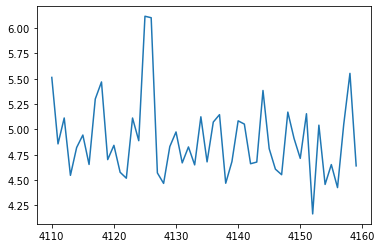

In [18]:
expt_cfg={"start":4110, "step":1, "expts":50, "reps": 20,"rounds":50,
          "probe_length":soccfg.us2cycles(2.0, gen_ch=0), "qubit_gain":1000 }
config = {**meas_cfg,**expt_cfg} #combine configs

# config['relax_delay'] = 1000

qspec = PulseProbeSpectroscopyProgram(soccfg, config)
# expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)

expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)

plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

# subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (GHz)", ylabel="Qubit Population")
# plot(expt_pts, avgi[0][0],'o-')
# axvline(qubit_cfg["f_ge"]);

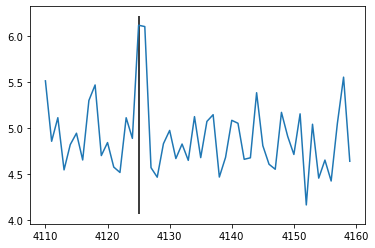

In [19]:
plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

# subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (GHz)", ylabel="Qubit Population")
# plot(expt_pts, avgi[0][0],'o-')
# axvline(qubit_cfg["f_ge"]);

fqux = 4125
plt.vlines(fqux, *plt.ylim())

meas_cfg.update(f_ge = fqux)

In [20]:
class LengthRabiProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        length_gen = self.us2cycles(cfg['readout_length'], gen_ch=cfg["res_ch"])
        length_ro = self.us2cycles(cfg['readout_length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"])

        self.declare_gen(ch=cfg["res_ch"], nqz=2) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        self.declare_readout(ch=cfg['ro_ch'], length=length_ro,
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])

#         self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
#         self.r_freq=self.sreg(cfg["qubit_ch"], "freq")   # get frequency register for qubit_ch    
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=cfg['ro_ch']) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

#         self.f_start =self.freq2reg(cfg["start"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies
#         self.f_step =self.freq2reg(cfg["step"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=f_ge, phase=0, gain=cfg["qubit_gain"], 
                                 length=cfg["pulse_length"])
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=length_gen)
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg['ro_ch']],
             adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

  0%|          | 0/500 [00:00<?, ?it/s]

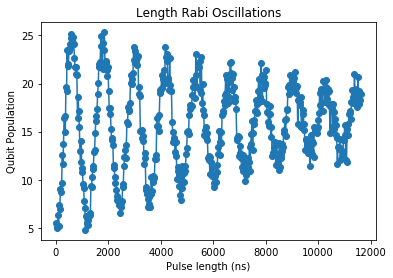

In [21]:
expt_cfg={ "qubit_gain": 4000,
           "start":4, "step":10, "expts":500, "reps": 400,
           "relax_delay": 400}

config={**meas_cfg,**expt_cfg} #combine configs

# qspec=PulseProbeSpectroscopyProgram(soccfg, config)
# # expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)
# expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)

# plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

expt_pts=[expt_cfg["start"] + ii*expt_cfg["step"] for ii in range(expt_cfg["expts"])]

results=[]
for length in tqdm(expt_pts):
    config["pulse_length"]=length

    rabi=LengthRabiProgram(soccfg, config)
#     avgi,avgq = rabi.acquire(soc, threshold=readout_cfg["threshold"], load_pulses=True, progress=False,debug=False)
    avgi,avgq = rabi.acquire(soc, load_pulses=True, progress=False,debug=False)
#     print((avgi+1j*avgq)[0][0])
    
    results.append(np.abs((avgi+1j*avgq)[0][0]))

subplot(111, title="Length Rabi Oscillations", xlabel="Pulse length (ns)", ylabel="Qubit Population")
plot(soccfg.cycles2us(np.array(expt_pts), gen_ch=0)*1000,results,'o-');


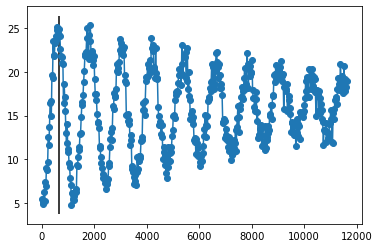

In [26]:
plot(soccfg.cycles2us(np.array(expt_pts), gen_ch=0)*1000,results,'o-');

pi_time = 640
plt.vlines(pi_time, *plt.ylim())

meas_cfg.update(pi_flat = dict(time = pi_time*1E-3, gain = config['qubit_gain']), relax_delay = config['relax_delay'])

In [27]:
class T1Program(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"]+1)     # get register page for qubit_ch
        self.r_wait = 3
        self.regwi(self.q_rp, self.r_wait, cfg["start"])

        length_gen = self.us2cycles(cfg['readout_length'], gen_ch=cfg["res_ch"])
        length_ro = self.us2cycles(cfg['readout_length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"])

        self.declare_gen(ch=cfg["res_ch"], nqz=2) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        self.declare_readout(ch=cfg['ro_ch'], length=length_ro,
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])

        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=cfg['ro_ch']) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        self.f_start =self.freq2reg(cfg["start"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies
        self.f_step =self.freq2reg(cfg["step"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=f_ge, phase=0, gain=cfg['pi_flat']["gain"], 
                                 length=self.us2cycles(cfg["pi_flat"]["time"]))
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=length_gen)
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all() # align channels and wait 50ns
        self.sync(self.q_rp,self.r_wait)

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg['ro_ch']],
             adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index

  0%|          | 0/60000 [00:00<?, ?it/s]

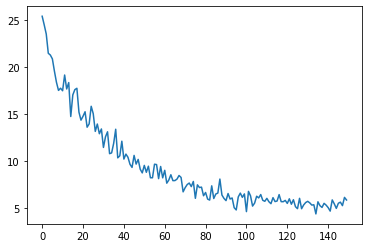

In [28]:
expt_cfg={"start":0, "step":1, "expts":150, "reps": 400}

config={**meas_cfg,**expt_cfg} #combine configs

qspec=T1Program(soccfg, config)
# expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)
expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)

plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

In [29]:
class AmplitudeRabiProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp = self.ch_page(cfg["qubit_ch"]+1)     # get register page for qubit_ch
        self.r_gain = self.sreg(cfg["qubit_ch"]+1, "gain")   # get gain register for qubit_ch    

        length_gen = self.us2cycles(cfg['readout_length'], gen_ch=cfg["res_ch"])
        length_ro = self.us2cycles(cfg['readout_length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"])

        self.declare_gen(ch = cfg["res_ch"], nqz = 2) #Readout
        self.declare_gen(ch = cfg["qubit_ch"], nqz =2) #Qubit
        
        self.declare_readout(ch=cfg['ro_ch'], length=length_ro,
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])

        f_res = self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=cfg['ro_ch']) # conver f_res to dac register value
        f_ge = self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["start"],
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=length_gen)
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns
#         self.sync(self.q_rp,self.r_wait)

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg['ro_ch']],
             adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the Gaussian pi pulse


  0%|          | 0/15000 [00:00<?, ?it/s]

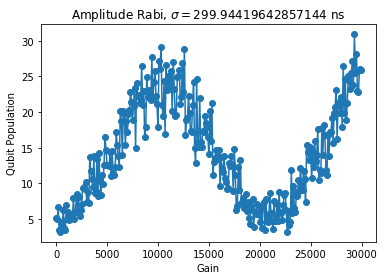

In [30]:
expt_cfg={"start":0, "step":100, "expts":300, "reps": 50,
          "sigma":soccfg.us2cycles(0.300, gen_ch=0) }

config={**meas_cfg,**expt_cfg} #combine configs

qspec = AmplitudeRabiProgram(soccfg, config)
# expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)
expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)

plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

subplot(111, title= f"Amplitude Rabi, $\sigma={soccfg.cycles2us(config['sigma'], gen_ch=0)*1000}$ ns", xlabel="Gain", ylabel="Qubit Population" )
plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]),'o-')

# axvline(qubit_cfg["pi_gain"])
# axvline(qubit_cfg["pi2_gain"]);

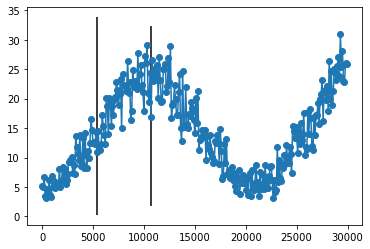

In [31]:
plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]),'o-')

pi_gain = 10700
pi2_gain = pi_gain/2

plt.vlines(pi_gain, *plt.ylim())
plt.vlines(pi2_gain, *plt.ylim())

meas_cfg.update(pi_gauss = dict(gain = pi_gain, sigma=expt_cfg['sigma']))
meas_cfg.update(pi2_gauss = dict(gain = pi2_gain, sigma=expt_cfg['sigma']))

# Dispersive shift & single shot readout

In [32]:
class SingleShotProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        length_gen = self.us2cycles(cfg['readout_length'], gen_ch=cfg["res_ch"])
        length_ro = self.us2cycles(cfg['readout_length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"])
        
        self.declare_gen(ch = cfg["res_ch"], nqz = 2) #Readout
        self.declare_gen(ch = cfg["qubit_ch"], nqz =2) #Qubit
        
        self.declare_readout(ch=cfg['ro_ch'], length=length_ro,
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        self.q_rp = self.ch_page(cfg["qubit_ch"]+1)     # get register page for qubit_ch
        self.r_gain = self.sreg(cfg["qubit_ch"]+1, "gain")   # get gain register for qubit_ch   
        
        f_res = self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=cfg['ro_ch']) # conver f_res to dac register value
        f_ge = self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg['pi_gauss']["sigma"], length=cfg['pi_gauss']["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["start"],
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=length_gen)   

        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg['ro_ch']],
             adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
    
    def update(self):
        self.mathi(self.q_rp, self.r_gain, self.r_gain, '+', self.cfg["step"])
        
    def acquire(self, soc, load_pulses=True, progress=False, debug=False):
        super().acquire(soc, load_pulses=load_pulses, progress=progress, debug=debug)
        return self.collect_shots()
        
    def collect_shots(self):
        length_ro = self.us2cycles(self.cfg['readout_length']+self.cfg['readout_padding'], ro_ch=self.cfg["ro_ch"])
        
        shots_i0 = self.di_buf.reshape((self.cfg["expts"],self.cfg["reps"]))/length_ro
        shots_q0 = self.dq_buf.reshape((self.cfg["expts"],self.cfg["reps"]))/length_ro
        return shots_i0, shots_q0
        
    def analyze(self, shots_i, shots_q):
        plt.subplot(111, xlabel='I', ylabel='Q', title='Single Shot Histogram')
        plt.plot(shots_i[0],shots_q[0],'.',label='g')
        plt.plot(shots_i[1],shots_q[1],'.',label='e')
        plt.legend()
        plt.gca().set_aspect('equal', 'datalim')

  0%|          | 0/51 [00:00<?, ?it/s]

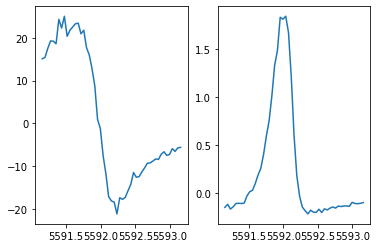

In [33]:
expt_cfg={"start":0, "step":meas_cfg['pi_gauss']['gain'], "expts":2, "reps": 300,
          "res_phase":0 }
config = {**meas_cfg,**expt_cfg} #combine configs

freqs = config['f_res'] + np.linspace(-1, 1, 51, dtype=float)
data = np.zeros((2,len(freqs)), dtype='complex')

for i, f in tqdm(list(enumerate(freqs))):
    config['f_res'] = f
    
    ssp = SingleShotProgram(soccfg, config)
    idata, qdata = ssp.acquire(soc, load_pulses=True,progress=False, debug=False)
    data[:, i] = np.mean(idata, axis=1) + 1j*np.mean(qdata, axis=1)
    

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(freqs, np.abs(data[0,:])-np.abs(data[1,:]), label='magnitude')
ax2.plot(freqs,  np.unwrap(np.angle(data[0,:]))-np.unwrap(np.angle(data[1,:])), label='phase')

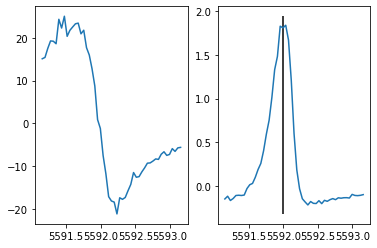

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(freqs, np.abs(data[0,:])-np.abs(data[1,:]), label='magnitude')
ax2.plot(freqs,  np.unwrap(np.angle(data[0,:]))-np.unwrap(np.angle(data[1,:])), label='phase')

ax2.vlines(5592, *plt.ylim())

In [35]:
expt_cfg={"start":0, "step":meas_cfg['pi_gauss']['gain'], "expts":2, "reps": 400,
          "res_phase":0 }

config={**meas_cfg, **expt_cfg} #combine configs

ssp = SingleShotProgram(soccfg, config)
idata, qdata = ssp.acquire(soc, load_pulses=True,progress=True, debug=False)

  0%|          | 0/800 [00:00<?, ?it/s]

(0.5634517766497462, 16.782121731128242, 2.0242297368464057)

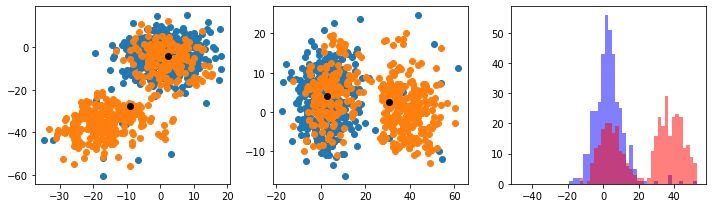

In [36]:
ig, ie = idata
qg, qe = qdata

xg, yg = np.median(ig), np.median(qg)
xe, ye = np.median(ie), np.median(qe)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
ranx = 100.0
rany = 60.0
numbins = 50

ax1.scatter(ig, qg)
ax1.scatter(ie, qe)
ax1.scatter(xg, yg, marker='o', color='k')
ax1.scatter(xe, ye, marker='o', color='k')

theta = -np.arctan2((ye-yg),(xe-xg))

ig_new = ig*np.cos(theta) - qg*np.sin(theta)
qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
ie_new = ie*np.cos(theta) - qe*np.sin(theta)
qe_new = ie*np.sin(theta) + qe*np.cos(theta)

xg, yg = np.median(ig_new), np.median(qg_new)
xe, ye = np.median(ie_new), np.median(qe_new)

ax2.scatter(ig_new, qg_new)
ax2.scatter(ie_new, qe_new)
ax2.scatter(xg, yg, marker='o', color='k')
ax2.scatter(xe, ye, marker='o', color='k')

xlims = [xg-ranx//2, xg+ranx//2]
ylims = [yg-rany//2, yg+rany//2]

ng, binsg, pg = ax3.hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
ne, binse, pe = ax3.hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)  
    
plt.tight_layout()

contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
tind = contrast.argmax()
threshold = binsg[tind]
fid = contrast[tind]

fid, threshold, theta

In [37]:
meas_cfg.update(res_phase = soccfg.deg2reg(-theta*180/pi, gen_ch=5),
                threshold = round(threshold))

In [38]:
meas_cfg

{'res_ch': 2,
 'qubit_ch': 0,
 'ro_ch': 0,
 'f_res': 5592.155,
 'res_phase': 2911274138,
 'res_gain': 1995,
 'pulse_gain': 6000,
 'pulse_freq': 5500,
 'nqz': 2,
 'adc_trig_offset': 0.55,
 'length': 10,
 'readout_padding': 0,
 'relax_delay': 400,
 'readout_length': 4,
 'f_ge': 4125,
 'pi_flat': {'time': 0.64, 'gain': 4000},
 'pi_gauss': {'gain': 10700, 'sigma': 129},
 'pi2_gauss': {'gain': 5350.0, 'sigma': 129},
 'threshold': 17}

# Active reset

In [39]:
class ActiveResetProgram(RAveragerProgram):        
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp = self.ch_page(cfg["qubit_ch"]+1)     # get register page for qubit_ch
        self.r_gain = self.sreg(cfg["qubit_ch"]+1, "gain")   # get gain register for qubit_ch  
        
        self.r_gain2=4
        self.regwi(self.q_rp, self.r_gain2, cfg["start"])        

        self.r_thresh = 6
        self.regwi(0,self.r_thresh,config["threshold"]*cfg["readout_length"])
        
        length_gen = self.us2cycles(cfg['readout_length'], gen_ch=cfg["res_ch"])
        length_ro = self.us2cycles(cfg['readout_length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"])
        
        self.declare_gen(ch=cfg["res_ch"], nqz=2) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        
        self.declare_readout(ch=cfg['ro_ch'], length=length_ro,
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg['pi_gauss']["sigma"], length=cfg['pi_gauss']["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["start"], 
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=length_gen)       
        
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.mathi(self.q_rp,self.r_gain,self.r_gain2,"+",0)
        
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05))
        
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=[self.cfg['ro_ch']],
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]))
        
        self.wait_all(200) # pause until 200 clocks past the end of the readout window
        self.read(0,0,"lower",2)  # lower & upper words of storage of IQ values
        self.read(0,0,"upper",3)  # 2 & 3 are magic number for 
        self.condj(0,2,'<',self.r_thresh,'after_reset')

        self.regwi(self.q_rp, self.r_gain, self.cfg['pi_gauss']["gain"])  #pi pulse qubit
        self.pulse(ch=self.cfg["qubit_ch"], t=0)

        self.label('after_reset')
        self.sync_all(self.us2cycles(1)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg['ro_ch']],
             adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]),
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_gain2, self.r_gain2, '+', self.cfg["step"]) # update frequency list index
        

In [40]:
expt_cfg={"start":0, "step":100, "expts":300, "reps": 400 }

config={**meas_cfg, **expt_cfg} #combine configs

areset = ActiveResetProgram(soccfg, config)
expt_pts, avgi,avgq = areset.acquire(soc, threshold=meas_cfg["threshold"], readouts_per_experiment=2, save_experiments=[0,1], load_pulses=True, progress=True)

subplot(111,title="Active Reset", xlabel="Pulse Amplitude", ylabel="Qubit Population")
plot(expt_pts,avgi[0][0],'o-', label="pre-reset")
plot(expt_pts,avgi[0][1], 'o-', label="post-reset")
legend();


  0%|          | 0/240000 [00:00<?, ?it/s]

NameError: name 'angle' is not defined

In [ ]:
subplot(111,title="Active Reset", xlabel="Pulse Amplitude", ylabel="Qubit Population")
plot(expt_pts,avgi[0][0],'o-', label="pre-reset")
plot(expt_pts,avgi[0][1], 'o-', label="post-reset")
legend();